# Autoencoders

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image.

Autoencoders are good to:

* To separate the noise of the signal.

* Identify mainly features.

* Detect anomalies.

In [1]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [2]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

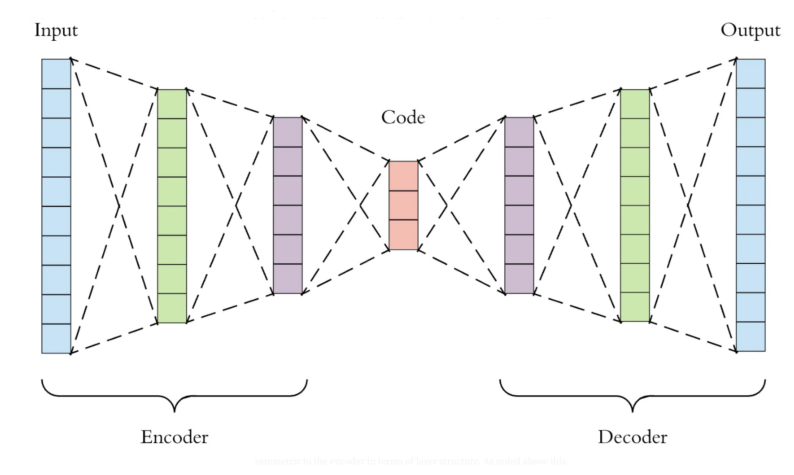

In [3]:
display_img('Autoencoders.png', 10, 10)

### Import libraries

In [4]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [5]:
start = time.time()

# 1. Basic autoencoder

### a. Load dataset

In [6]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### b. Create the model

In [8]:
class Autoencoder(Model):

  def __init__(self, latent_dim, shape):

    super(Autoencoder, self).__init__()

    self.latent_dim = latent_dim

    self.shape = shape

    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation = 'relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation = 'sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):

    encoded = self.encoder(x)

    decoded = self.decoder(encoded)

    return decoded

In [9]:
shape = x_test.shape[1:]
latent_dim = 64

In [10]:
autoencoder = Autoencoder(latent_dim, shape)

In [11]:
autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = losses.MeanSquaredError())

### c. Train the model

In [12]:
autoencoder.fit(x_train, x_train,
                epochs = 20,
                shuffle = True,
                validation_data = (x_test, x_test))

Epoch 1/20
1875/1875 [==============================] - 13s 6ms/step - loss: 0.0235 - val_loss: 0.0132
Epoch 2/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0

### d. Show

In [13]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

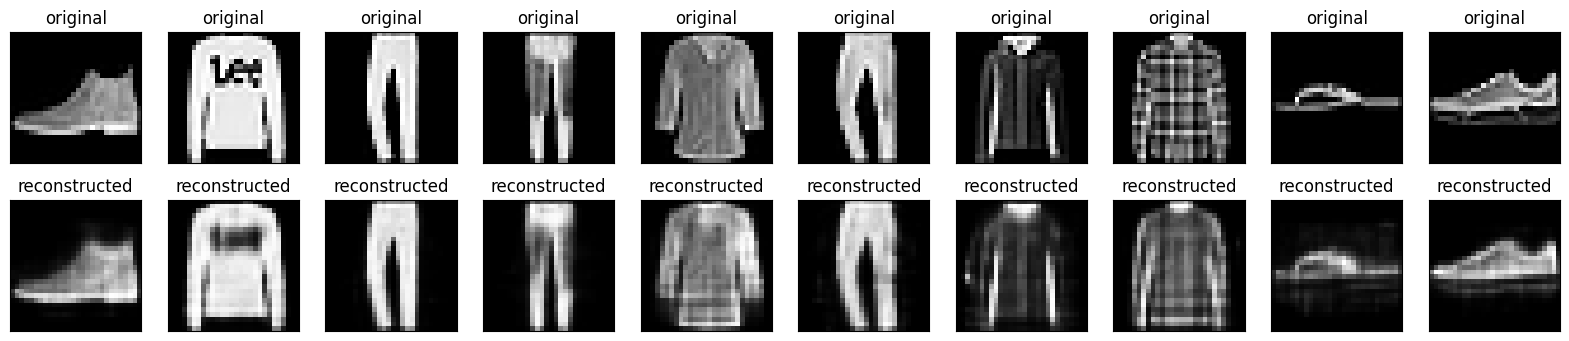

In [14]:
n = 10

plt.figure(figsize = (20, 4))

for i in range(n):

  # display original

  ax = plt.subplot(2, n, i + 1)

  plt.imshow(x_test[i])

  plt.title("original")

  plt.gray()

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction

  ax = plt.subplot(2, n, i + 1 + n)

  plt.imshow(decoded_imgs[i])

  plt.title("reconstructed")

  plt.gray()

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# 2. Convolutional Encoding: Image Denoising

### a. Load dataset

In [15]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [16]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [17]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### b. Adding noise

In [18]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape = x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape = x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min = 0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min = 0., clip_value_max=1.)

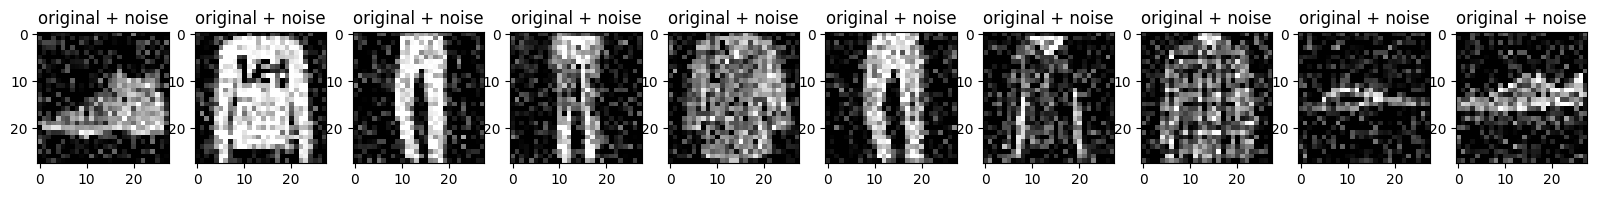

In [19]:
n = 10

plt.figure(figsize = (20, 2))

for i in range(n):

  ax = plt.subplot(1, n, i + 1)

  plt.title("original + noise")

  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()

plt.show()

### c. Create model

In [20]:
class Denoise(Model):

  def __init__(self):

    super(Denoise, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same', strides = 2),
      layers.Conv2D(8, (3, 3), activation = 'relu', padding = 'same', strides = 2)
      ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
      layers.Conv2DTranspose(16, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same'),
      layers.Conv2D(1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')
      ])

  def call(self, x):

    encoded = self.encoder(x)

    decoded = self.decoder(encoded)

    return decoded

In [21]:
autoencoder = Denoise()

In [22]:
autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss=losses.MeanSquaredError())

### d. Train the model

In [23]:
autoencoder.fit(x_train_noisy, x_train,
                epochs = 20,
                shuffle = True,
                validation_data = (x_test_noisy, x_test))

Epoch 1/20
1875/1875 [==============================] - 65s 34ms/step - loss: 0.0157 - val_loss: 0.0093
Epoch 2/20
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 3/20
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/20
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 5/20
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 6/20
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/20
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/20
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/20
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/20
1875/1875 [==============================] - 59s 31m

### e. Show

In [24]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

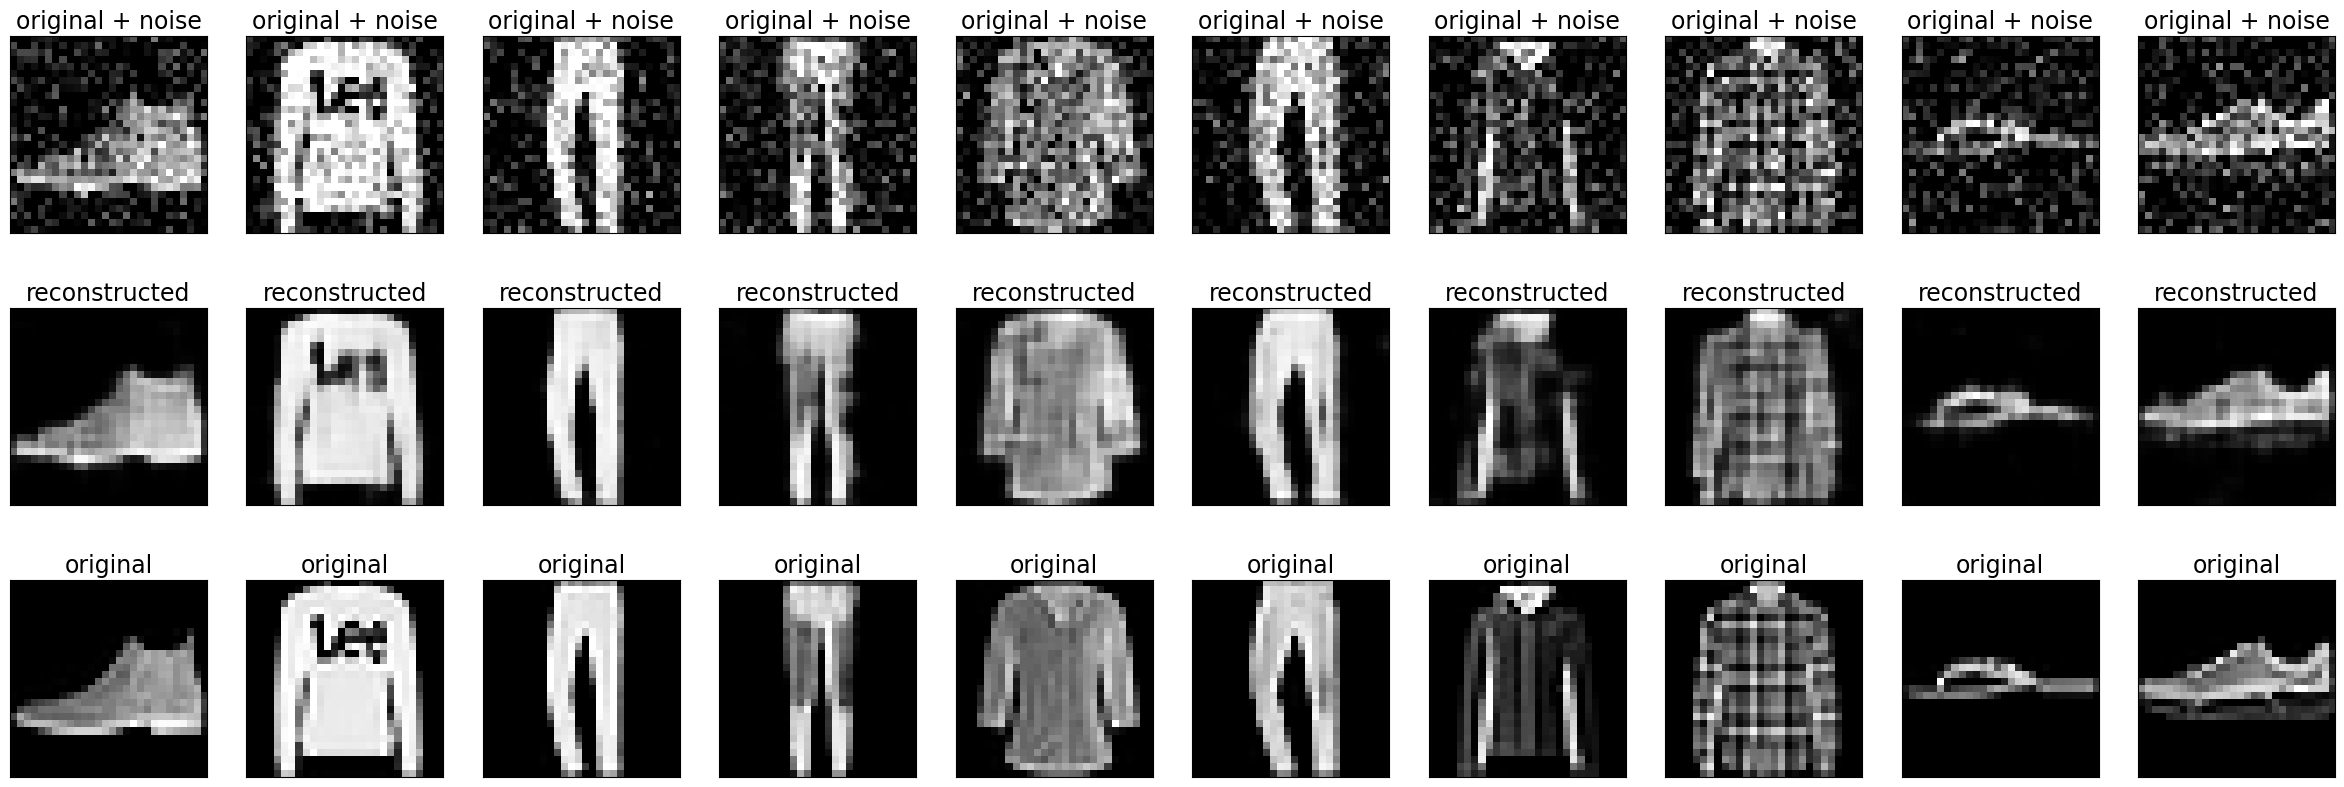

In [25]:
n = 10

plt.figure(figsize = (30, 10))

for i in range(n):

  # display original

  ax = plt.subplot(3, n, i + 1)

  plt.imshow(tf.squeeze(x_test_noisy[i]))

  plt.title("original + noise", fontsize = 17)

  plt.gray()

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction

  ax = plt.subplot(3, n, i + 1 + n)

  plt.imshow(tf.squeeze(decoded_imgs[i]))

  plt.title("reconstructed", fontsize = 17)

  plt.gray()

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display original

  ax = plt.subplot(3, n, i + 1 + 2*n)

  plt.imshow(x_test[i])

  plt.title("original", fontsize = 17)

  plt.gray()

  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

# 3. Anomaly Detection

In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### a. Load data

In [26]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [27]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize

In [28]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [29]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG.

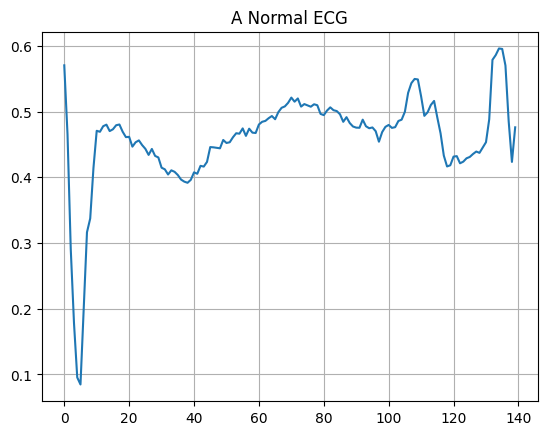

In [30]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

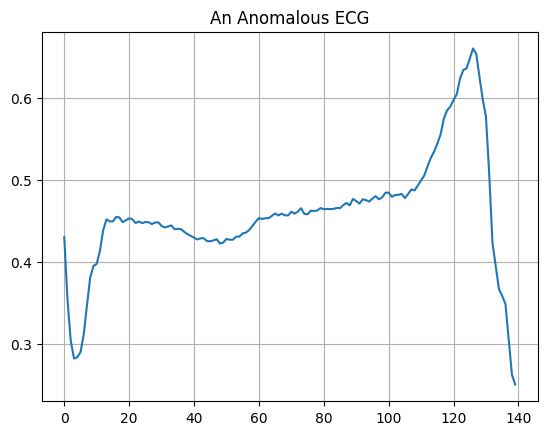

In [31]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### b. Create the model

In [32]:
class AnomalyDetector(Model):

  def __init__(self):

    super(AnomalyDetector, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")
      ])

  def call(self, x):

    encoded = self.encoder(x)

    decoded = self.decoder(encoded)

    return decoded

In [33]:
autoencoder = AnomalyDetector()

In [34]:
autoencoder.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mae')

### c. Train the model

In [35]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs = 20,
          batch_size = 512,
          validation_data = (test_data, test_data),
          shuffle = True)

Epoch 1/20
5/5 [==============================] - 1s 51ms/step - loss: 0.0577 - val_loss: 0.0527
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0550 - val_loss: 0.0505
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0516 - val_loss: 0.0484
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0474 - val_loss: 0.0466
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0433 - val_loss: 0.0443
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0394 - val_loss: 0.0426
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0359 - val_loss: 0.0409
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0331 - val_loss: 0.0401
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0310 - val_loss: 0.0389
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0293 - val_loss: 0.0383
Epoch 11/20
5/5 [===============

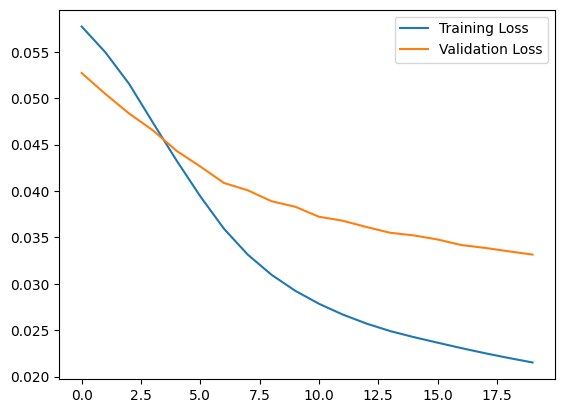

In [36]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

### d. Show

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

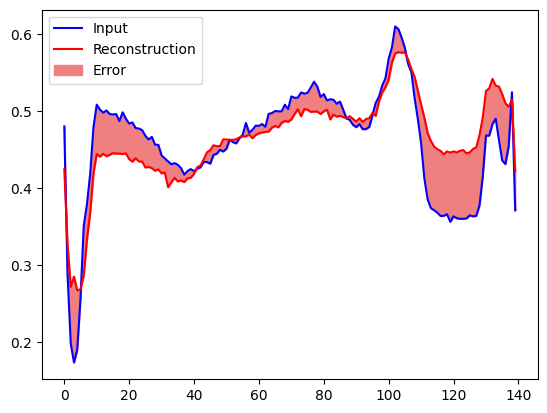

In [37]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

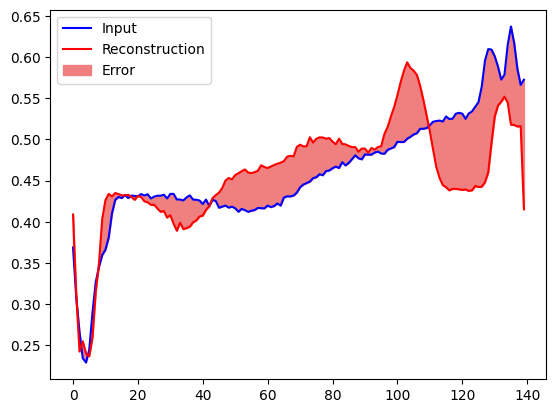

In [38]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### e. Detecting anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set:

74/74 [==============================] - 0s 1ms/step


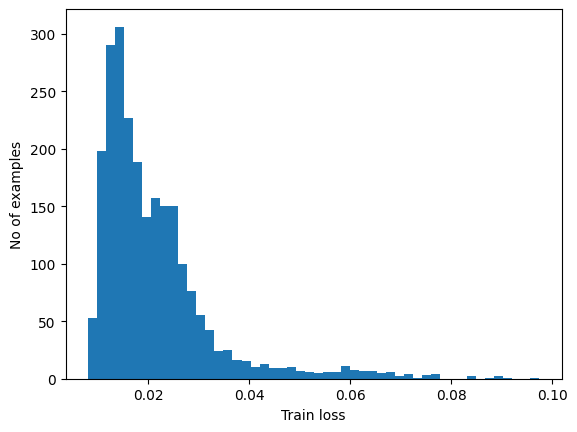

In [39]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [40]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032876566


Ploting error on anomalies.

14/14 [==============================] - 0s 1ms/step


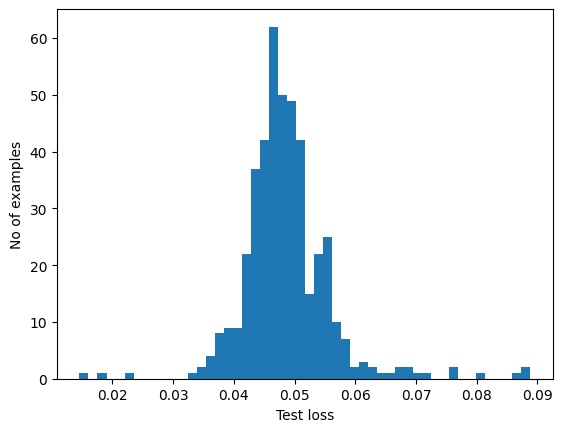

In [41]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [42]:
def predict(model, data, threshold):

  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)

  return tf.math.less(loss, threshold)

In [43]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(round(accuracy_score(labels, predictions)*100, 2)))
  print("Precision = {}".format(round(precision_score(labels, predictions)*100, 2)))
  print("Recall = {}".format(round(recall_score(labels, predictions)*100, 2)))

In [44]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 94.3
Precision = 99.22
Recall = 90.54


### Time of execution

In [45]:
end = time.time()

In [46]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 23 minutes and 57 seconds.
